In [35]:
import pandas as pd
import numpy as np
import json
import pip
import re
from urllib.request import urlopen
import requests
from wikidata.client import Client
from scipy import stats
import powerlaw
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle
from fa2 import ForceAtlas2
import operator
from backbone import *
import community
from collections import Counter
from scipy.stats import poisson
import warnings
warnings.filterwarnings('ignore')

# Preparing the data

In [40]:
df = pd.read_pickle("connections.pkl")
poli = df[['name','group', 'chamber','links','area']]
poli.head()

,name,group,chamber,links,area
0,A. Donald McEachin,Democrat,House of Representatives,"[Virginia, Randy Forbes, Virginia's 9th Senate...",Virginia's 4th congressional district
1,A. Drew Ferguson IV,Republican,House of Representatives,[Party leaders of the United States House of R...,Georgia's 3rd congressional district
2,Abby Finkenauer,Democrat,House of Representatives,"[Iowa, Ashley Hinson, Rod Blum, Pat Murphy (Io...",Iowa's 1st congressional district
3,Abigail Davis Spanberger,Democrat,House of Representatives,"[Virginia, Dave Brat, Red Bank, New Jersey, De...",Virginia's 7th congressional district
4,Adam B. Schiff,Democrat,House of Representatives,[United States House Permanent Select Committe...,California's 28th congressional district


In [42]:
# Including the sentiment score for each politician in the dataframe
sent_df = pd.read_csv('..\\sentiment_ion.csv', sep=';')
sent_df.drop(columns=['Unnamed: 0'], inplace=True)
df2 = sent_df.groupby('name')['sentiment'].apply(np.mean)
df2 = df2.to_frame()

In [44]:
# Dataframe for analysis is made
final_df = poli.join(df2, on='name')
final_df.head()

,name,group,chamber,links,area,sentiment
0,A. Donald McEachin,Democrat,House of Representatives,"[Virginia, Randy Forbes, Virginia's 9th Senate...",Virginia's 4th congressional district,0.324517
1,A. Drew Ferguson IV,Republican,House of Representatives,[Party leaders of the United States House of R...,Georgia's 3rd congressional district,0.130850
2,Abby Finkenauer,Democrat,House of Representatives,"[Iowa, Ashley Hinson, Rod Blum, Pat Murphy (Io...",Iowa's 1st congressional district,-0.022567
3,Abigail Davis Spanberger,Democrat,House of Representatives,"[Virginia, Dave Brat, Red Bank, New Jersey, De...",Virginia's 7th congressional district,0.376050
4,Adam B. Schiff,Democrat,House of Representatives,[United States House Permanent Select Committe...,California's 28th congressional district,-0.028800


# Graph Creation

In [45]:
def graphCreator(DG, df):
    # Creating directed network and adding attributes
    for politician in df.name:
        party = df.loc[df.name == politician, 'group'].values[0]
        chamber = df.loc[df.name == politician, 'chamber'].values[0]
        sentiment = df.loc[df.name == politician, 'sentiment'].values[0]
        area = df.loc[df.name == politician, 'area'].values[0]
        DG.add_nodes_from([(politician, {'Party' : party, 'Chamber' : chamber, 'Sentiment' : sentiment, 'Area' : area})])

        links = df.loc[df.name == politician, 'links'].values[0]
        linkCounts = Counter(links)
        
        # Linking politicians based on the links on their wikipages
        try:
            for name in df.name:
                if name in linkCounts.keys():
                    party = df.loc[df.name == name, 'group'].values[0]
                    DG.add_nodes_from([(name, {'Party' : party})])
                    DG.add_edge(politician, name, weight = linkCounts[name])
        except TypeError:
            pass

In [47]:
DG = nx.DiGraph()
graphCreator(DG, final_df)

In [48]:
print(f'Nodes: {DG.number_of_nodes()}')
print(f'Edges: {DG.number_of_edges()}\n')

#Only using the largest component
nodes = max(nx.weakly_connected_components(DG), key=len)
DG = DG.subgraph(nodes).copy()

print(f'Nodes: {DG.number_of_nodes()}')
print(f'Edges: {DG.number_of_edges()}\n')

Nodes: 540
Edges: 2365

Nodes: 523
Edges: 2363



# Graph Analysis

In [50]:
count = 0
for a,b in DG.edges():
    if DG.nodes[a]['Party'] != DG.nodes[b]['Party']:
        count = count+1
print(f'Number of links between Democrats and Republicans: {count}')

count = 0
for a,b in DG.edges():
    if DG.nodes[a]['Chamber'] != DG.nodes[b]['Chamber']:
        count = count+1
print(f'Number of links between The house of representatives and senate: {count}')

Number of links between Democrats and Republicans: 788
Number of links between The house of representatives and senate: 366


In [10]:
in_degrees = sorted((d for n, d in DG.in_degree()), reverse=False)
out_degrees = sorted((d for n, d in DG.out_degree()), reverse=True)

print(f'in-degree stats: \nMean: {np.mean(in_degrees)} \nMedian: {np.median(in_degrees)}   \nMode: {stats.mode(in_degrees)} \nMinimum:  {np.min(in_degrees)} \nMaximum: {np.max(in_degrees)} \n')

print(f'out-degree stats: \nMean: {np.mean(out_degrees)} \nMedian: {np.median(out_degrees)}   \nMode: {stats.mode(out_degrees)} \nMinimum:  {np.min(out_degrees)} \nMaximum: {np.max(out_degrees)}')

in-degree stats: 
Mean: 4.5181644359464626 
Median: 2.0   
Mode: ModeResult(mode=array([0]), count=array([218])) 
Minimum:  0 
Maximum: 153 

out-degree stats: 
Mean: 4.5181644359464626 
Median: 3.0   
Mode: ModeResult(mode=array([2]), count=array([107])) 
Minimum:  0 
Maximum: 29


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


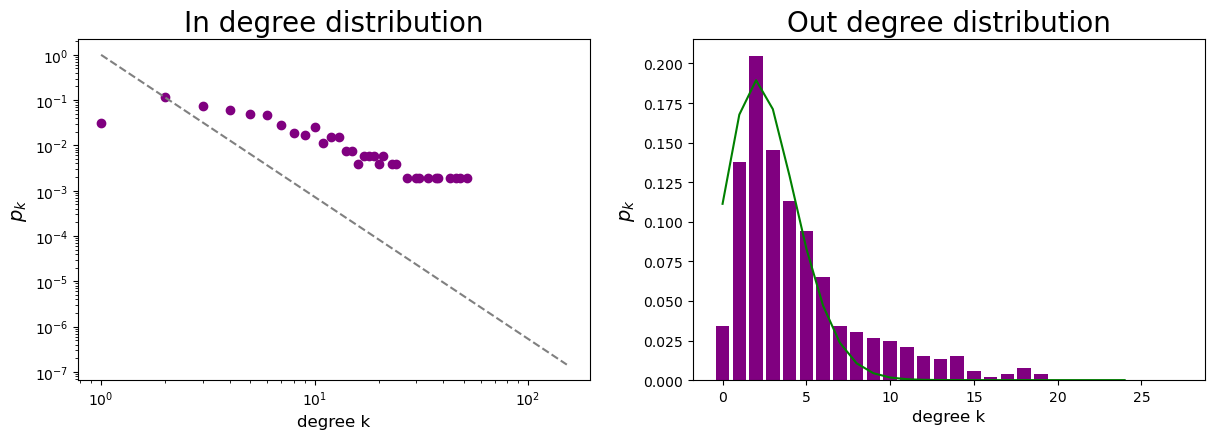

In [51]:
# Binning the degree distribution
bins_in_degrees = np.arange(np.min(in_degrees),np.max(in_degrees),1)
freq_in_degrees, hist_in_degrees = np.histogram(in_degrees, bins = bins_in_degrees);
bins_out_degrees = np.arange(np.min(out_degrees),np.max(out_degrees),1)
freq_out_degrees, hist_out_degrees = np.histogram(out_degrees, bins = bins_out_degrees);

p_k_in = [i/np.sum(freq_in_degrees) for i in freq_in_degrees]
p_k_out = [i/np.sum(freq_out_degrees) for i in freq_out_degrees]


# Plotting
# Indegrees
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.tight_layout()
ax1.set_title('In degree distribution', fontsize = 20)
ax1.set_xlabel('degree k', fontsize = 12)
ax1.set_ylabel("$p_{k}$", fontsize = 14)
ax1.set_xscale("log");
ax1.set_yscale("log");
ax1.scatter(hist_in_degrees[:-1], p_k_in, color = 'purple');

## Outdegrees
ax2.set_title('Out degree distribution', fontsize = 20)
ax2.set_xlabel('degree k', fontsize = 12)
ax2.set_ylabel('$p_{k}$', fontsize = 14)
#ax2.set_xlim(0,100)
#ax2.set_ylim(0,0.08)
#ax2.bar(*np.unique(out_degrees, return_counts=True), color = 'purple');
#ax2.bar(hist_out_degrees[:-1], freq_out_degrees, color = 'purple');
ax2.bar(hist_out_degrees[:-1], p_k_out, color = 'purple');
lam = np.mean(out_degrees)
fitted_dist = poisson(lam, loc=-2)
x = np.arange(0, 25)
y = fitted_dist.pmf(x)
ax2.plot(x, y, 'g-')
plt.subplots_adjust(wspace = 0.2)

# Fitting a powerlaw to the data to check if it has scalefree properties
fit = powerlaw.Fit(in_degrees)
gamma = fit.alpha
powerlaw_fit = [d**(-gamma) for d in hist_in_degrees[1:]]
ax1.plot(hist_in_degrees[1:], powerlaw_fit, c = 'grey', linestyle='dashed');


In [12]:
top_in_degrees = sorted(DG.in_degree(), key = operator.itemgetter(1,0), reverse = True)
top_out_degrees = sorted(DG.out_degree(), key = operator.itemgetter(1,0), reverse = True)

print(f'Top 10 in_degree:')
for name, count in top_in_degrees[:10]:
    print(f"{name :<25}: {count}")
    
print(f'\nTop 10 out_degree:')
for name, count in top_out_degrees[:10]:
    print(f"{name:<25}: {count}")

Top 10 in_degree:
Nancy Pelosi             : 153
Mitch McConnell          : 52
Ted Cruz                 : 48
Mitt Romney              : 46
Elizabeth Warren         : 43
Rand Paul                : 38
Marco Rubio              : 37
Lindsey Graham           : 34
John Cornyn              : 31
Alexandria Ocasio-Cortez : 30

Top 10 out_degree:
Chip Roy                 : 29
Tom Cotton               : 19
Kevin McCarthy           : 19
Paul A. Gosar            : 18
Mike Lee                 : 18
Joe Manchin, III         : 18
Charles E. Schumer       : 18
Patrick J. Leahy         : 17
Doug Jones               : 17
Liz Cheney               : 16


# Drawing the graph

In [52]:
# Convert to undirected graph for plotting
UGCC = DG.to_undirected()

# Remove nodes with low degree for nicer and tighter plot
nodes_to_remove = [node for node,degree in dict(UGCC.degree()).items() if degree < 2]
UGCC.remove_nodes_from(nodes_to_remove)

In [53]:
print(f'Nodes: {UGCC.number_of_nodes()}')
print(f'Edges: {UGCC.number_of_edges()}\n')

Nodes: 485
Edges: 1925



In [54]:
# Assigning node colors and sizes based on party and degree
node_color = []
for node, attribute in UGCC.nodes(data=True):
    if attribute['Party'] == 'Republican':
        node_color.append('red')
    else:
        node_color.append('Blue')

edge_color = []
for n1, n2 in UGCC.edges():
    uni1 = UGCC.nodes[n1]['Party']
    uni2 = UGCC.nodes[n2]['Party']
    if uni1 == 'Republican' and uni2 == 'Republican':
        edge_color.append('orange')
    elif uni1 != uni2:
        edge_color.append('green')
    else:
        edge_color.append('yellow')
        
        
##################################################################################################################       
# Assigning node colors based on chamber
node_color_chamber = []
for node, attribute in UGCC.nodes(data=True):
    if attribute['Chamber'] == 'House of Representatives':
        node_color_chamber.append('green')
    else:
        node_color_chamber.append('yellow')

edge_color_chamber = []
for n1, n2 in UGCC.edges():
    uni1 = UGCC.nodes[n1]['Chamber']
    uni2 = UGCC.nodes[n2]['Chamber']
    if uni1 == 'House of Representatives' and uni2 == 'House of Representatives':
        edge_color_chamber.append('orange')
    elif uni1 != uni2:
        edge_color_chamber.append('red')
    else:
        edge_color_chamber.append('blue')

####################################################################################################################
d = dict(UGCC.degree).values()
scale = 10
node_size = [degree*scale for degree in d]

In [55]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2,
                        strongGravityMode=False,
                        gravity=1.5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(UGCC, pos=None, iterations=500);

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 149.71it/s]

BarnesHut Approximation  took  0.56  seconds
Repulsion forces  took  2.62  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds


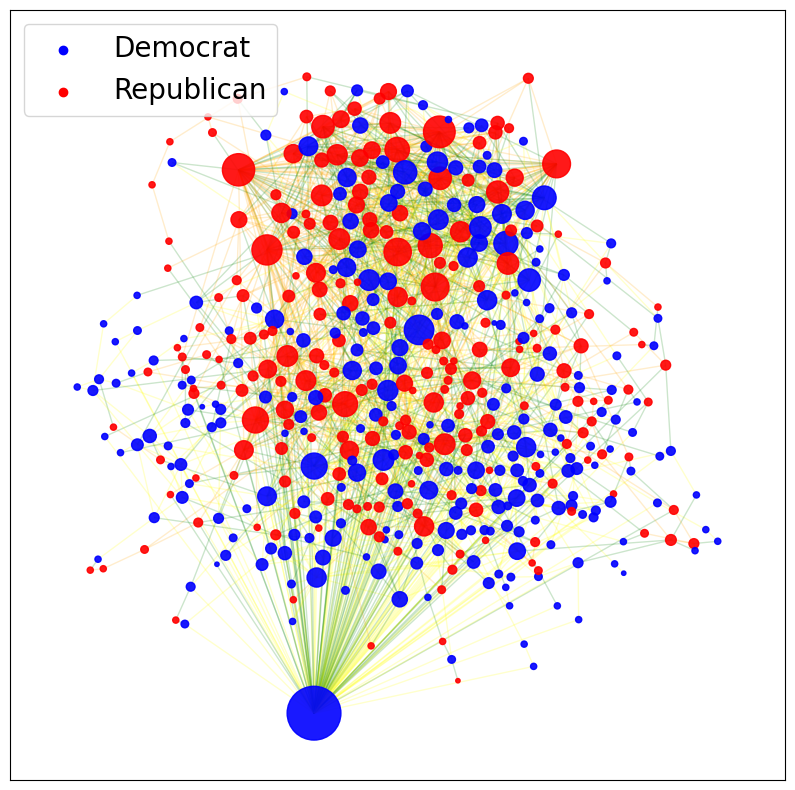

In [56]:
color = ['blue', 'red']
parties = ['Democrat','Republican']
plt.figure(1,figsize=(10,10)) 
#plt.title('Graph of Republican and Democratic candidates based on connections')
nx.draw_networkx_nodes(UGCC, pos = positions, node_size=node_size, node_color=node_color, alpha=0.9);
nx.draw_networkx_edges(UGCC, pos = positions, edge_color=edge_color, alpha=0.2);
for v in range(0,2):
    plt.scatter([],[], c=color[v], label=(parties[v]))
plt.legend(loc='upper left', prop={'size': 20})
plt.savefig('graph_party.png')
plt.show()

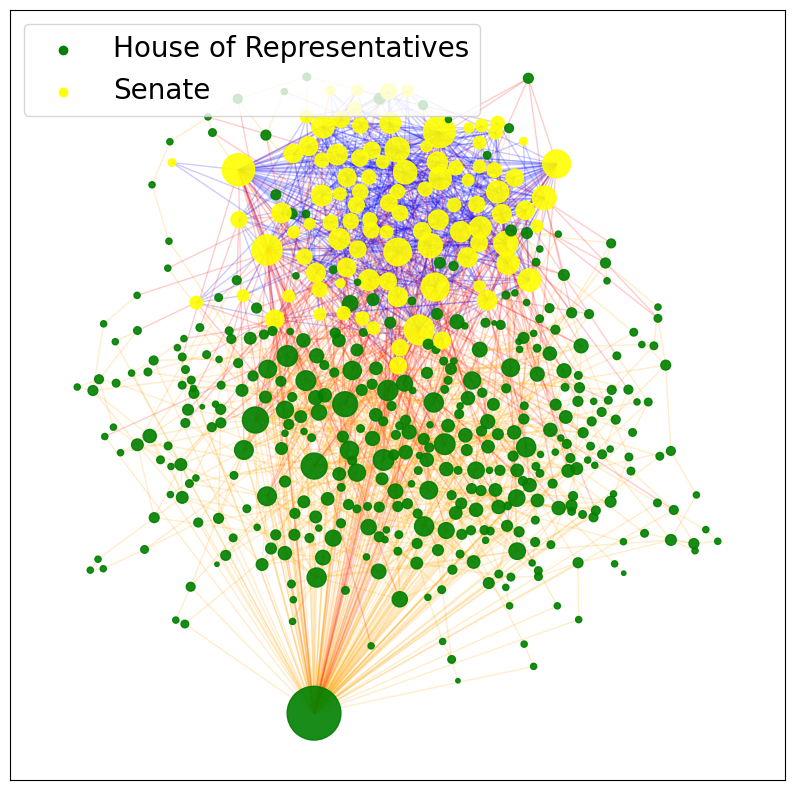

In [57]:
color = ['green', 'yellow']
chamb = ['House of Representatives','Senate']
plt.figure(1,figsize=(10,10)) 
#plt.title('Graph of Republican and Democratic candidates based on connections')
nx.draw_networkx_nodes(UGCC, pos = positions, node_size=node_size, node_color=node_color_chamber, alpha=0.9);
nx.draw_networkx_edges(UGCC, pos = positions, edge_color=edge_color_chamber, alpha=0.2);
for v in range(0,2):
    plt.scatter([],[], c=color[v], label=(chamb[v]))
plt.legend(loc='upper left', prop={'size': 20})
plt.savefig('graph_chamber.png')

plt.show()

# Finding comunities with Louvain

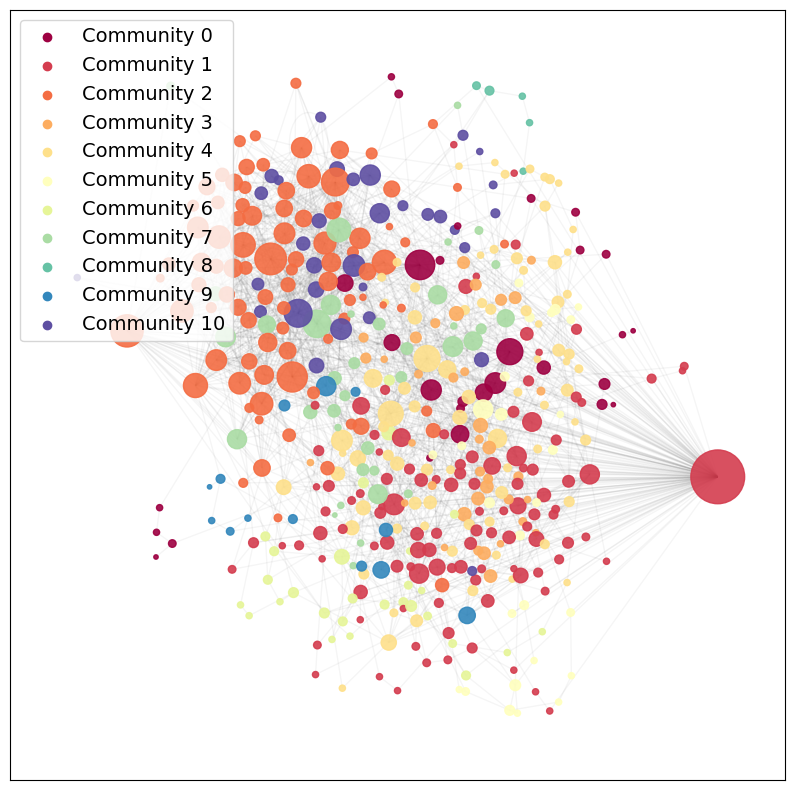

In [19]:
# Finding a partition with algorithm
partition = community.best_partition(UGCC, random_state = 1, randomize = False)

## Defining the color spectrum
maxvalue = np.max(list(partition.values())) 
cmap=plt.cm.Spectral
node_color = [cmap(v/maxvalue) for v in partition.values()]

# Plotting
plt.figure(1,figsize=(10,10)) 
nx.draw_networkx_nodes(UGCC, pos = positions, node_color=node_color, alpha=0.9, node_size = node_size);
nx.draw_networkx_edges(UGCC, pos = positions, alpha=0.04);

# Creating legend
for part in set(partition.values()):
    plt.scatter([],[], c=[cmap(part/maxvalue)], label='Community {}'.format(part))

plt.legend(loc='upper left', prop={'size': 14})
plt.savefig('graph_community.png')
plt.show()

###### Analysing found communities

In [58]:
# Dividing the found parition
partitions = []
for i in range(0, len(set(partition.values()))):
    partitions.append([])
    
for politician, com in partition.items():
    partitions[com].append(politician)

# sorting them by length
partitionsSorted = partitions
partitionsSorted.sort(key=len, reverse = True)

In [59]:
coms = []
for parti in partitions:
    coms.append([node for node in DG.nodes(data=True) if node[0] in parti]
)

In [61]:
# Checking how attributes relate in the found communities
for politician in coms[1]:
    name = politician[0]
    chamber = politician[1]['Chamber']
    party = politician[1]['Party']
    area = politician[1]['Area']

    print(f'{name :<25} {chamber :<30} {area :<30} {party}')

Chuck Grassley            Senate                         Iowa                           Republican
Brad Sherman              House of Representatives       California's 30th congressional district Democrat
Dianne Feinstein          Senate                         California                     Democrat
Billy Long                House of Representatives       Missouri's 7th congressional district Republican
Rob Portman               Senate                         Ohio                           Republican
Adrian Smith              House of Representatives       Nebraska's 3rd congressional district Republican
Peter Welch               House of Representatives       Vermont's at-large congressional district Democrat
David Kustoff             House of Representatives       Tennessee's 8th congressional district Republican
Albio Sires               House of Representatives       New Jersey's 8th congressional district Democrat
Robert Menendez           Senate                         New Jers

Comment: The algorithm tend to divide the communitites by chamber
Comment: The algorithm does not follow parties

In [62]:
# Calculating the average sentiment score per community
for co in coms:
    print(np.mean([poli[1]['Sentiment'] for poli in co if poli[1]['Sentiment'] == poli[1]['Sentiment']]))

0.12787778578709771
0.2571093146959158
0.2224094215506716
0.23747306628056628
0.12389215277777775
0.215286548859127
0.2245715968801314
0.07966776360544217
0.16674909798534798
0.05253783882783883
-0.029491746031746


Comment: That sentiment seems to differ slightly between communities.

# Centrality measures

**Degree**

In [63]:
sorted(DG.in_degree(), key = operator.itemgetter(1,0), reverse = True)[:10]

[('Nancy Pelosi', 153),
 ('Mitch McConnell', 52),
 ('Ted Cruz', 48),
 ('Mitt Romney', 46),
 ('Elizabeth Warren', 43),
 ('Rand Paul', 38),
 ('Marco Rubio', 37),
 ('Lindsey Graham', 34),
 ('John Cornyn', 31),
 ('Alexandria Ocasio-Cortez', 30)]

In [64]:
sorted(DG.out_degree(), key = operator.itemgetter(1,0), reverse = True)[:10]

[('Chip Roy', 29),
 ('Tom Cotton', 19),
 ('Kevin McCarthy', 19),
 ('Paul A. Gosar', 18),
 ('Mike Lee', 18),
 ('Joe Manchin, III', 18),
 ('Charles E. Schumer', 18),
 ('Patrick J. Leahy', 17),
 ('Doug Jones', 17),
 ('Liz Cheney', 16)]

**Betweenness Centrality**

In [65]:
sorted(nx.betweenness_centrality(DG).items(), key=lambda x: x[1], reverse=True)[:10]

[('Nancy Pelosi', 0.11977447287174023),
 ('Mitt Romney', 0.05226693498612595),
 ('Tom Cotton', 0.03208477198330774),
 ('Ted Cruz', 0.03166881287461206),
 ('Kyrsten Sinema', 0.026798068996890766),
 ('Ilhan Omar', 0.02651214383210003),
 ('Liz Cheney', 0.025921898207576004),
 ('Alexandria Ocasio-Cortez', 0.023871225333730876),
 ('Thomas Massie', 0.02192739097281948),
 ('Rand Paul', 0.020712478373683174)]

**Eigenvector Centrality**

In [66]:
sorted(nx.eigenvector_centrality(DG).items(), key=lambda x: x[1], reverse=True)[:10]

[('Mitch McConnell', 0.3631303789157147),
 ('Nancy Pelosi', 0.2565036722848349),
 ('John Cornyn', 0.25598884925770726),
 ('Rand Paul', 0.25585197805371596),
 ('Ted Cruz', 0.2542660706073187),
 ('Mitt Romney', 0.24643511059881515),
 ('Chuck Grassley', 0.1887104385921964),
 ('Lindsey Graham', 0.18734530811734942),
 ('Marco Rubio', 0.17434402641615032),
 ('Dianne Feinstein', 0.17370872263456708)]

# Assortativity

In [67]:
print(nx.attribute_assortativity_coefficient(DG, 'Party'))
print(nx.attribute_assortativity_coefficient(DG, 'Chamber'))
print(nx.attribute_assortativity_coefficient(DG, 'Sentiment'))
print(nx.degree_assortativity_coefficient(DG))

0.3397775010566147
0.6821232799678323
-0.0010522633723415178
-0.00915651334314478


# Modularity

**By Party**

In [68]:
democrats = [node[0] for node in DG.nodes(data=True) if node[1]['Party'] == 'Democrat']
republicans = [node[0] for node in DG.nodes(data=True) if node[1]['Party'] == 'Republican']
independents = [node[0] for node in DG.nodes(data=True) if node[1]['Party'] == 'Independent']
print(f'{nx.algorithms.community.modularity(DG, [democrats,republicans,independents])}')

0.18753473934637674


In [69]:
independents

['Angus S. King, Jr.', 'Bernard Sanders']

**By Chamber**

In [70]:
house = [node[0] for node in DG.nodes(data=True) if node[1]['Chamber'] == 'House of Representatives']
senate = [node[0] for node in DG.nodes(data=True) if node[1]['Chamber'] == 'Senate']
print(f'{nx.algorithms.community.modularity(DG, [house,senate])}')

0.33483672842848816


**By Algorithm**

In [72]:
coms = []
for i in range(0, len(set(partition.values()))):
    coms.append([])
    
for politician, com in partition.items():
    coms[com].append(politician)

print(f'{nx.algorithms.community.modularity(UGCC, coms)}')

0.4215980216305818


# Analysing each chamber as a separate network

In [73]:
house = [node[0] for node in DG.nodes(data=True) if node[1]['Chamber'] == 'House of Representatives']
senate = [node[0] for node in DG.nodes(data=True) if node[1]['Chamber'] == 'Senate']
Dcongress_network = DG.subgraph(house).copy()
nodes = max(nx.weakly_connected_components(Dcongress_network), key=len)
congress_network = Dcongress_network.subgraph(nodes).copy()
# Convert to undirected graph for plotting
congress_network = congress_network.to_undirected()


Dsenate_network = DG.subgraph(senate).copy()
# Convert to undirected graph for plotting
senate_network = Dsenate_network.to_undirected()

In [74]:
print(f'Nodes in congress: {congress_network.number_of_nodes()}')
print(f'Edges in congress: {congress_network.number_of_edges()}\n')

print(f'Nodes in senate: {senate_network.number_of_nodes()}')
print(f'Edges in senate: {senate_network.number_of_edges()}\n')

Nodes in congress: 418
Edges in congress: 997

Nodes in senate: 100
Edges in senate: 645



In [75]:
# Assigning node colors and sizes based on party and degree
node_color_congress = []
for node, attribute in congress_network.nodes(data=True):
    if attribute['Party'] == 'Republican':
        node_color_congress.append('red')
    else:
        node_color_congress.append('Blue')

edge_color_congress = []
for n1, n2 in congress_network.edges():
    uni1 = congress_network.nodes[n1]['Party']
    uni2 = congress_network.nodes[n2]['Party']
    if uni1 == 'Republican' and uni2 == 'Republican':
        edge_color_congress.append('orange')
    elif uni1 != uni2:
        edge_color_congress.append('green')
    else:
        edge_color_congress.append('yellow')
        
####################################################################################################################
d = dict(congress_network.degree).values()
scale = 10
node_size_congress = [degree*scale for degree in d]

########################################################################################
# Assigning node colors and sizes based on party and degree
node_color_senate = []
for node, attribute in senate_network.nodes(data=True):
    if attribute['Party'] == 'Republican':
        node_color_senate.append('red')
    else:
        node_color_senate.append('Blue')

edge_color_senate = []
for n1, n2 in senate_network.edges():
    uni1 = senate_network.nodes[n1]['Party']
    uni2 = senate_network.nodes[n2]['Party']
    if uni1 == 'Republican' and uni2 == 'Republican':
        edge_color_senate.append('orange')
    elif uni1 != uni2:
        edge_color_senate.append('green')
    else:
        edge_color_senate.append('yellow')
        
####################################################################################################################
d = dict(senate_network.degree).values()
scale = 20
node_size_senate = [degree*scale for degree in d]

In [76]:
positions_congress = forceatlas2.forceatlas2_networkx_layout(congress_network, pos=None, iterations=500);
positions_senate = forceatlas2.forceatlas2_networkx_layout(senate_network, pos=None, iterations=500);

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 163.90it/s]


BarnesHut Approximation  took  0.32  seconds
Repulsion forces  took  2.59  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1572.55it/s]

BarnesHut Approximation  took  0.05  seconds
Repulsion forces  took  0.23  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


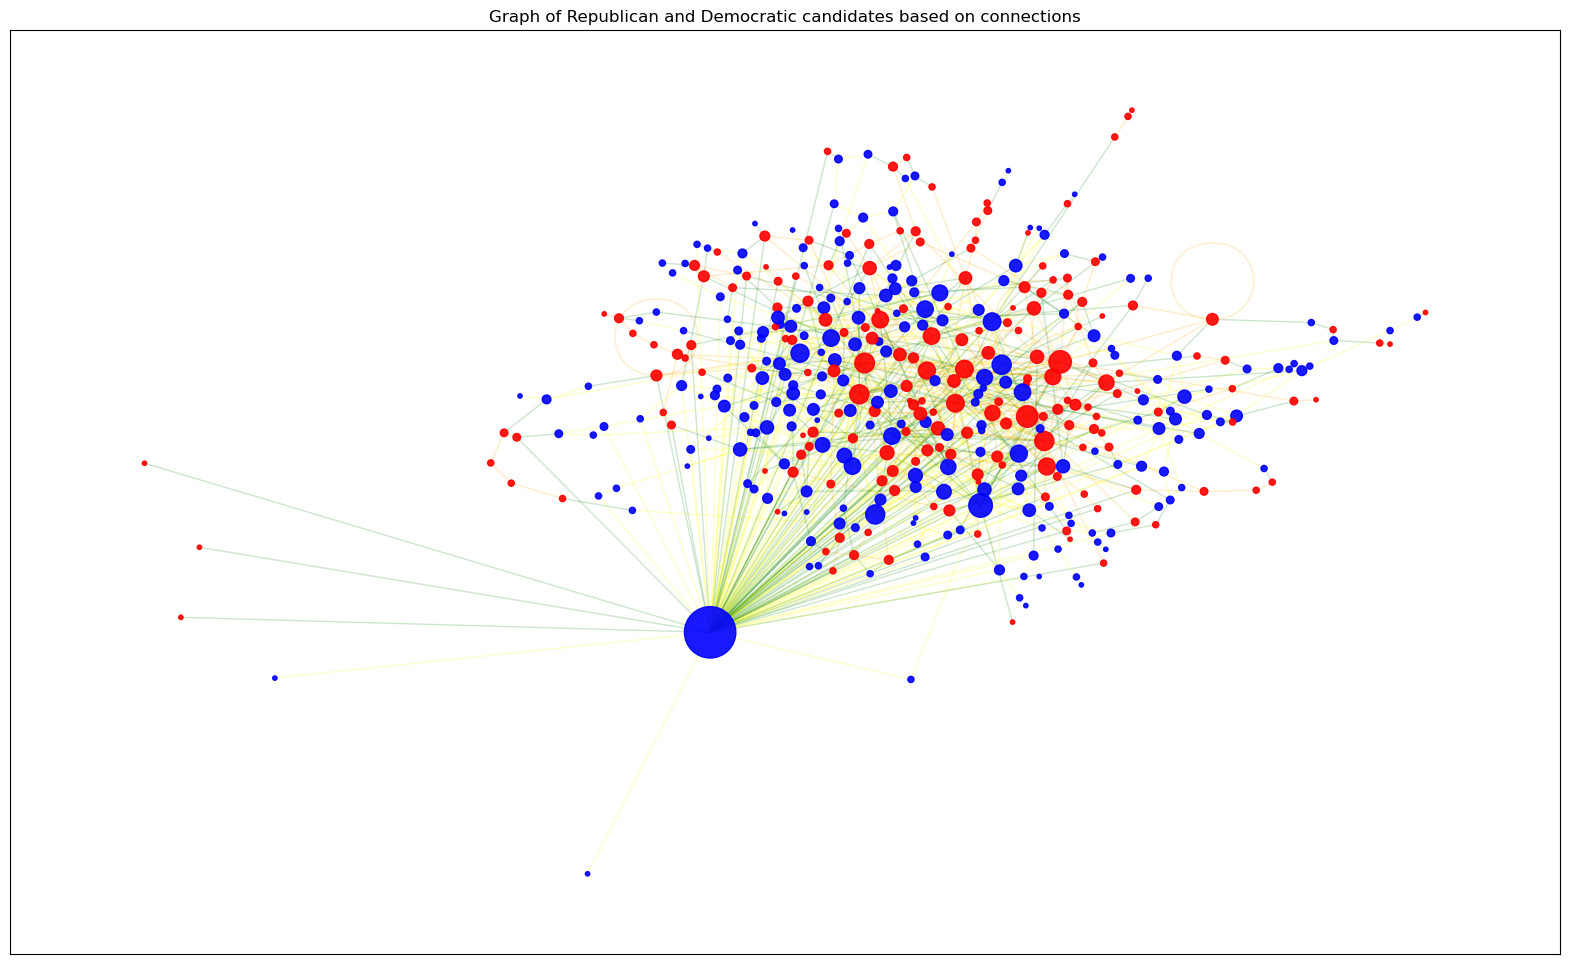

In [77]:
plt.figure(1,figsize=(20,12)) 
plt.title('Graph of Republican and Democratic candidates based on connections')
nx.draw_networkx_nodes(congress_network, pos = positions_congress, node_size=node_size_congress, node_color=node_color_congress, alpha=0.9);
nx.draw_networkx_edges(congress_network, pos = positions_congress, edge_color=edge_color_congress, alpha=0.2);
plt.show()

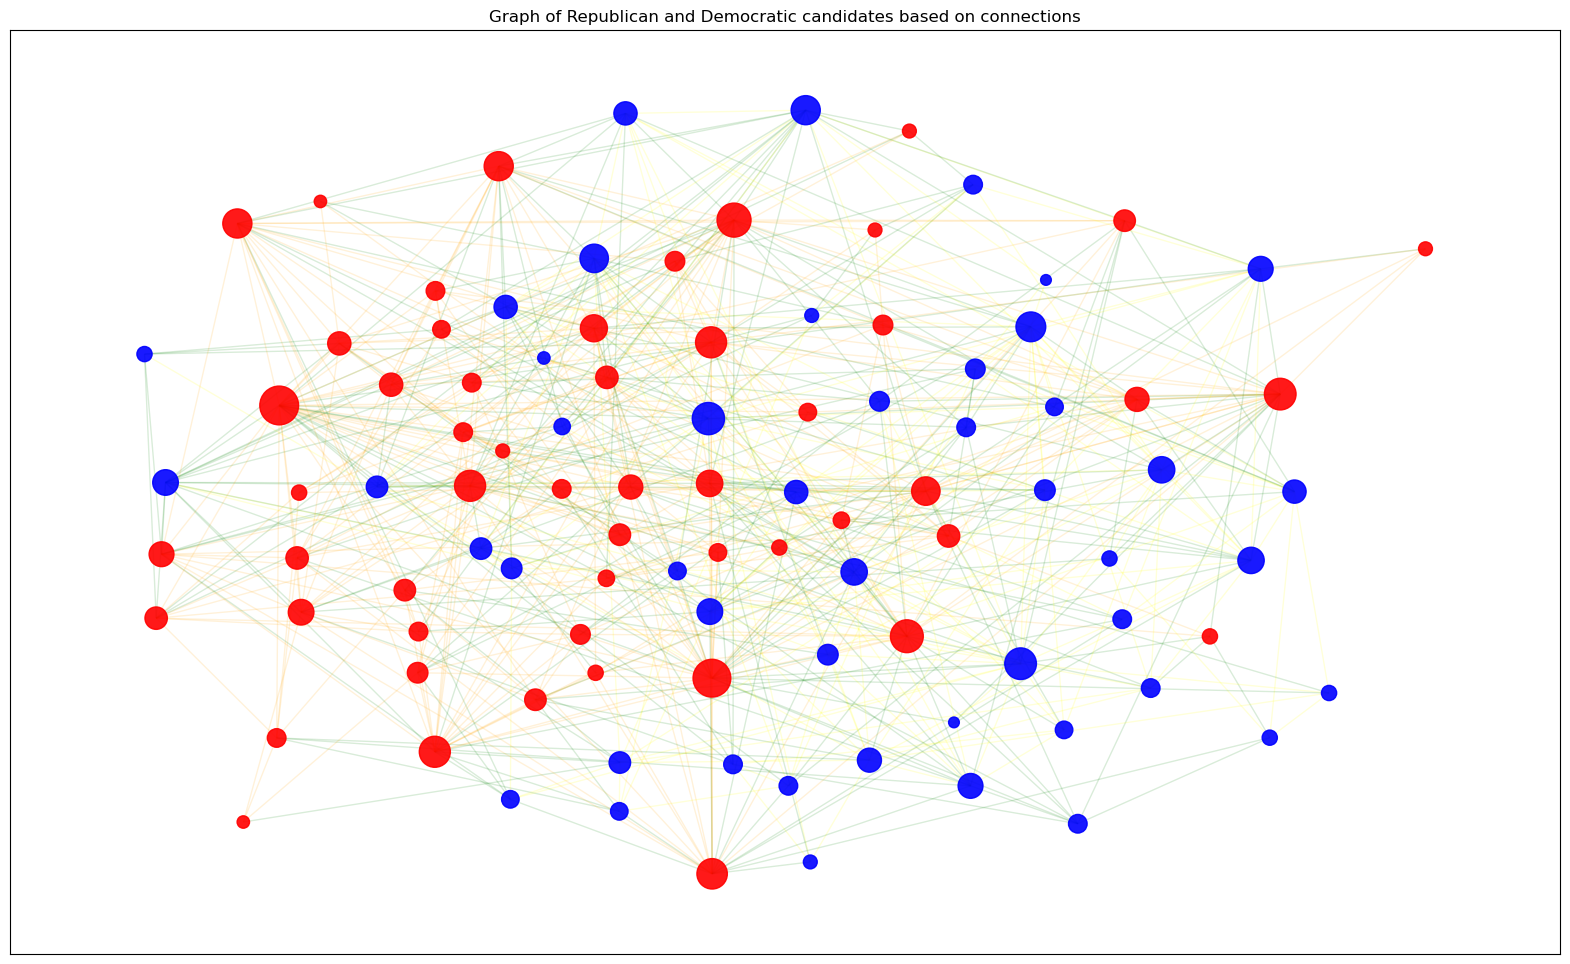

In [78]:
plt.figure(1,figsize=(20,12)) 
plt.title('Graph of Republican and Democratic candidates based on connections')
nx.draw_networkx_nodes(senate_network, pos = positions_senate, node_size=node_size_senate, node_color=node_color_senate, alpha=0.9);
nx.draw_networkx_edges(senate_network, pos = positions_senate, edge_color=edge_color_senate, alpha=0.15);
plt.show()

# Centrality measures for each chambers network

**Degree**

In [79]:
top_in_congress = sorted(Dcongress_network.in_degree(), key = operator.itemgetter(1,0), reverse = True)[:10]
top_out_congress = sorted(Dcongress_network.out_degree(), key = operator.itemgetter(1,0), reverse = True)[:10]

print(f'Top in degrees for congress network:') 
for politician, degree in top_in_congress:
    print(f'{politician :<25}: {degree}')
print(f'\nTop out degrees for congress network:') 
for politician, degree in top_out_congress:
    print(f'{politician :<25}: {degree}') 


Top in degrees for congress network:
Nancy Pelosi             : 137
Alexandria Ocasio-Cortez : 26
Steve Scalise            : 20
Liz Cheney               : 20
Cheri Bustos             : 18
Ilhan Omar               : 16
John Lewis               : 15
John Katko               : 15
Matt Gaetz               : 14
Devin Nunes              : 14

Top out degrees for congress network:
Chip Roy                 : 22
Kevin McCarthy           : 19
Paul A. Gosar            : 15
Elise M. Stefanik        : 13
Hakeem S. Jeffries       : 11
Ted Lieu                 : 10
Liz Cheney               : 10
Justin Amash             : 10
Cheri Bustos             : 10
Ayanna Pressley          : 10


In [80]:
top_in_senate = sorted(Dsenate_network.in_degree(), key = operator.itemgetter(1,0), reverse = True)[:10]
top_out_senate = sorted(Dsenate_network.out_degree(), key = operator.itemgetter(1,0), reverse = True)[:10]

print(f'Top in degrees for senate network:') 
for politician, degree in top_in_senate:
    print(f'{politician :<25}: {degree}')
print(f'\nTop out degrees for senate network:') 
for politician, degree in top_out_senate:
    print(f'{politician :<25}: {degree}') 

Top in degrees for senate network:
Mitch McConnell          : 39
Ted Cruz                 : 33
Marco Rubio              : 26
Rand Paul                : 25
John Cornyn              : 25
Patty Murray             : 24
Lindsey Graham           : 24
Elizabeth Warren         : 24
Mitt Romney              : 23
Dianne Feinstein         : 20

Top out degrees for senate network:
Joe Manchin, III         : 17
Tom Cotton               : 16
Mike Lee                 : 15
Rob Portman              : 14
Patrick J. Leahy         : 14
Jerry Moran              : 14
Doug Jones               : 14
Charles E. Schumer       : 14
Susan M. Collins         : 13
Roy Blunt                : 13


**Betweenness Centrality**

In [81]:
top_between_congress = sorted(nx.betweenness_centrality(Dcongress_network).items(), key=lambda x: x[1], reverse=True)[:10]
print(f'Top Betweenness Centrality for congress network:') 
for politician, between in top_between_congress:
    print(f'{politician :<25}: {between}')

Top Betweenness Centrality for congress network:
Nancy Pelosi             : 0.11130907077099435
Ilhan Omar               : 0.056096592658740445
Ayanna Pressley          : 0.040426881467462074
Liz Cheney               : 0.03866659712361346
Cheri Bustos             : 0.036899550780256134
Ro Khanna                : 0.0361000495825761
Thomas Massie            : 0.03495885435928832
Barbara Lee              : 0.03291879041140114
Alexandria Ocasio-Cortez : 0.032738874215748906
Tulsi Gabbard            : 0.029021631280891188


In [82]:
top_between_senate = sorted(nx.betweenness_centrality(Dsenate_network).items(), key=lambda x: x[1], reverse=True)[:10]
print(f'Top Betweenness Centrality for senate network:') 
for politician, between in top_between_senate:
    print(f'{politician :<25}: {between}')

Top Betweenness Centrality for senate network:
Mitt Romney              : 0.0631690692832498
Tom Cotton               : 0.046704664638547354
Ted Cruz                 : 0.04652647532187283
Lindsey Graham           : 0.03767927362648816
Rob Portman              : 0.03035734803764004
Marco Rubio              : 0.02913398829792326
Joni Ernst               : 0.028659794098118366
John Cornyn              : 0.025804675073933747
Rand Paul                : 0.025400485043212115
Chuck Grassley           : 0.025215822464669056


**Eigenvector Centrality**

In [83]:
top_eigen_congress = sorted(nx.eigenvector_centrality(Dcongress_network).items(), key=lambda x: x[1], reverse=True)[:10]
print(f'Top Eigenvector Centrality for congress network:') 
for politician, eigen in top_eigen_congress:
    print(f'{politician :<25}: {eigen}')

Top Eigenvector Centrality for congress network:
Nancy Pelosi             : 0.6612976769068295
Ilhan Omar               : 0.23900262525546428
Devin Nunes              : 0.22232105084903847
Alexandria Ocasio-Cortez : 0.19330251256946948
Justin Amash             : 0.17741843244517502
Ro Khanna                : 0.17482148073537015
Ted Lieu                 : 0.17412118933863469
Cheri Bustos             : 0.15350843996142116
Rashida Tlaib            : 0.1458573042863054
Debbie Dingell           : 0.14077091207256076


In [84]:
top_eigen_senate = sorted(nx.eigenvector_centrality(Dsenate_network).items(), key=lambda x: x[1], reverse=True)[:10]
print(f'Top Eigenvector Centrality for senate network:') 
for politician, eigen in top_eigen_senate:
    print(f'{politician :<25}: {eigen}')

Top Eigenvector Centrality for senate network:
Mitch McConnell          : 0.36975138256097717
John Cornyn              : 0.2959154070683921
Ted Cruz                 : 0.26565727595196403
Rand Paul                : 0.2522463715959919
Mitt Romney              : 0.22783700680124422
Chuck Grassley           : 0.21108397695265682
Lindsey Graham           : 0.19889226888121267
John Thune               : 0.19651010055503904
Dianne Feinstein         : 0.18314630789765401
Marco Rubio              : 0.17910478407030198


# Assortativity

In [85]:
print(nx.attribute_assortativity_coefficient(Dcongress_network, 'Party'))
print(nx.attribute_assortativity_coefficient(Dcongress_network, 'Sentiment'))
print(nx.degree_assortativity_coefficient(Dcongress_network))

0.3405643591962033
-0.00018739371699633183
-0.0226819432247379


In [86]:
print(nx.attribute_assortativity_coefficient(Dsenate_network, 'Party'))
print(nx.attribute_assortativity_coefficient(Dsenate_network, 'Sentiment'))
print(nx.degree_assortativity_coefficient(Dsenate_network))

0.23077287290288967
-0.009224817735456033
0.06087401847052846


Comment: People tend to connect with people from the same party more often in the congress than the senate

# Modularity

**By Party**

In [87]:
democrats = [node[0] for node in Dcongress_network.nodes(data=True) if node[1]['Party'] == 'Democrat']
republicans = [node[0] for node in Dcongress_network.nodes(data=True) if node[1]['Party'] == 'Republican']
independents = [node[0] for node in Dcongress_network.nodes(data=True) if node[1]['Party'] == 'Independent']
print(f'{nx.algorithms.community.modularity(Dcongress_network, [democrats,republicans,independents])}')

0.18756213525184223


In [88]:
democrats = [node[0] for node in Dsenate_network.nodes(data=True) if node[1]['Party'] == 'Democrat']
republicans = [node[0] for node in Dsenate_network.nodes(data=True) if node[1]['Party'] == 'Republican']
independents = [node[0] for node in Dsenate_network.nodes(data=True) if node[1]['Party'] == 'Independent']
print(f'{nx.algorithms.community.modularity(Dsenate_network, [democrats,republicans,independents])}')

0.12277708333333329
